In [1]:
import numpy as np
import astropy.units as u
import time
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
import poppy
import skimage
from skimage.registration import phase_cross_correlation
import copy
from importlib import reload

import magpyx
from magpyx.utils import ImageStream
import purepyindi
from purepyindi import INDIClient
client0 = purepyindi.INDIClient('localhost', 7624)
client0.start()

from math_module import xp, xcipy, np_array
import utils
import fsm_utils
import cam_utils
from imshows import imshow1, imshow2, imshow3
from matplotlib.patches import Circle

v_bias = np.array([[50,50,50]]).T

wavelength = 633e-9
fl = 450e-3
fsm_pupil_diam = 7.2e-3
as_per_lamD = (wavelength/fsm_pupil_diam*u.radian).to(u.arcsec)
print(as_per_lamD)

pxscl_lamD = 3.45e-6 / (fl * wavelength/fsm_pupil_diam)
print(pxscl_lamD)

/opt/conda/envs/km310gpu/lib/python3.10/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


18.134114215890555 arcsec
0.0872037914691943


In [6]:
reload(cam_utils)
cam = cam_utils.CAM('campupil')


In [3]:
npsf =200
cam.set_roi(540, 900, npsf, client0)

In [4]:
cam.set_exptime(0.0001, client0)

INFO:utils:Got semaphore index 1.


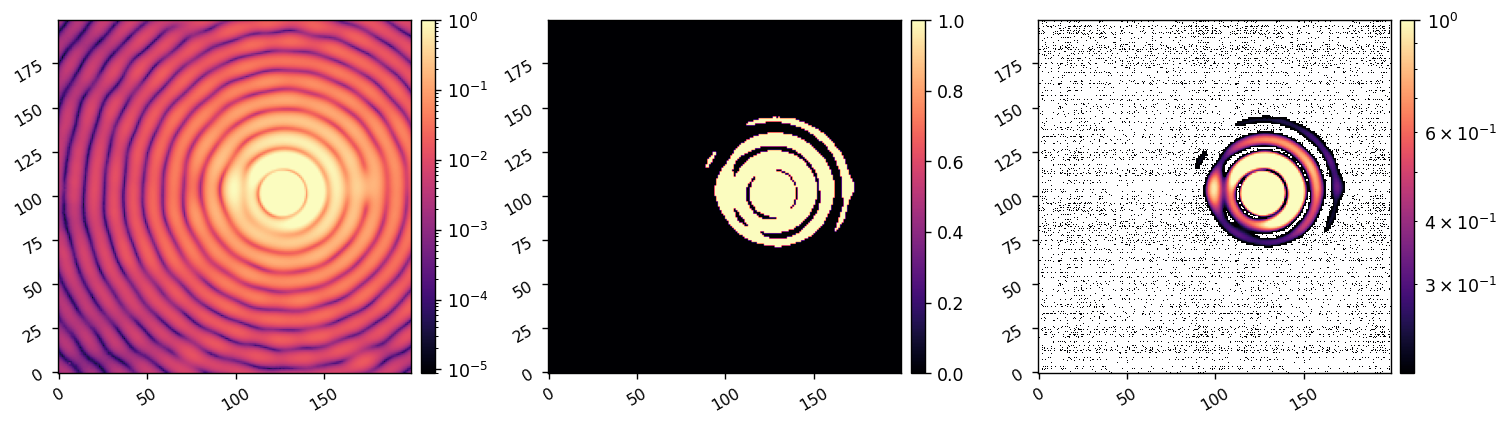

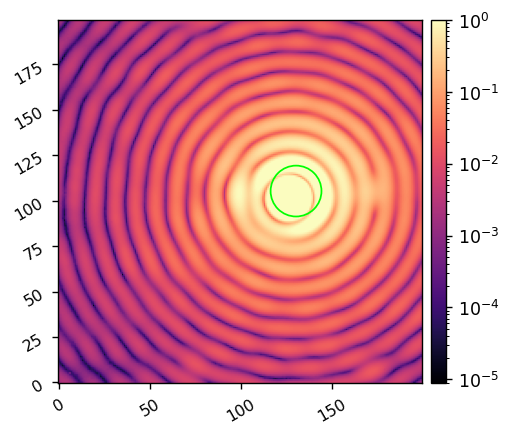

In [7]:
cam.Nframes = 1000
im = cam.snap()

reload(utils)
cen = utils.centroid(im, thresh=0.2, plot=True)
imshow1(im, lognorm=True, patches=[Circle(cen, 1.22/pxscl_lamD, fill=False, color='lime')])


In [8]:
fsm = ImageStream('fsm')
fsm.write(v_bias)

In [9]:
fsm.buffer

array([[50.],
       [50.],
       [50.]], dtype=float32)

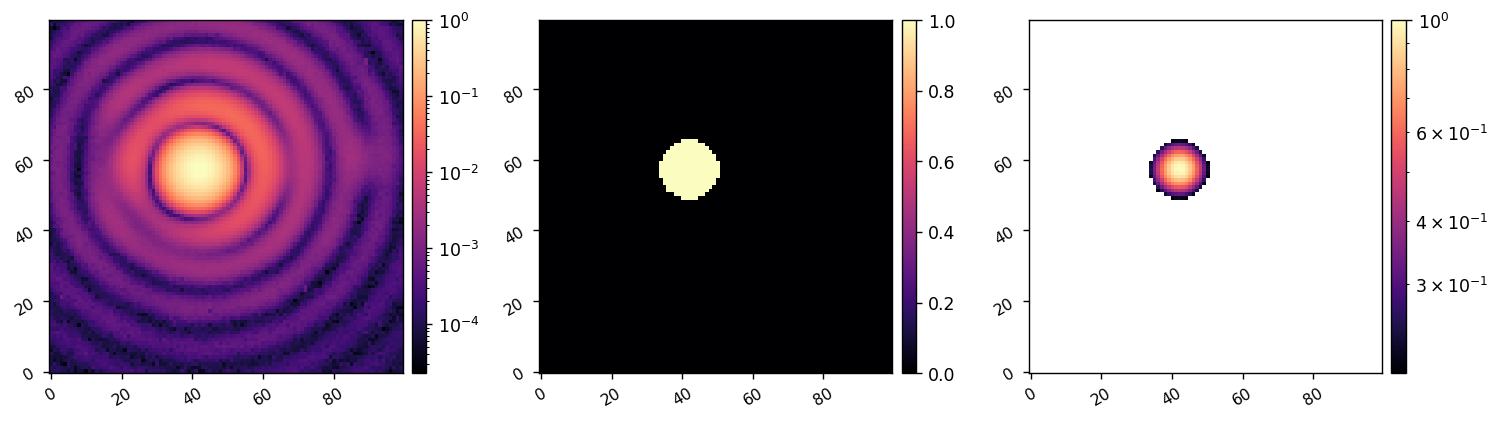

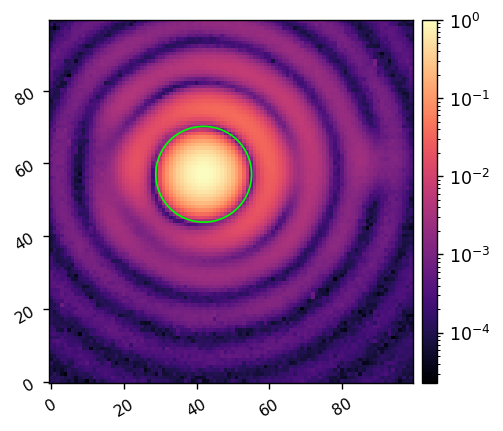

In [45]:
cam.Nframes = 5000
im_bias_1 = cam.snap()

reload(utils)
cen_1 = utils.centroid(im_bias_1, thresh=0.2, plot=True)
imshow1(im_bias_1, lognorm=True, patches=[Circle(cen_1, 1.22/pxscl_lamD, fill=False, color='lime')])


In [49]:
time.sleep(2)
# fsm.write(np.array([[50,50,50]]).T)
reload(fsm_utils)
tip = 0.2
v_tt = fsm_utils.get_fsm_volts(tip=tip*as_per_lamD, tilt=0*as_per_lamD)
fsm.write(v_tt)

Displacements: A = 5.13e-06 m, 4.94e-06 m, 4.94e-06 m. 
Delta Voltages: A = 51.29, B = 49.36, C = 49.36. 


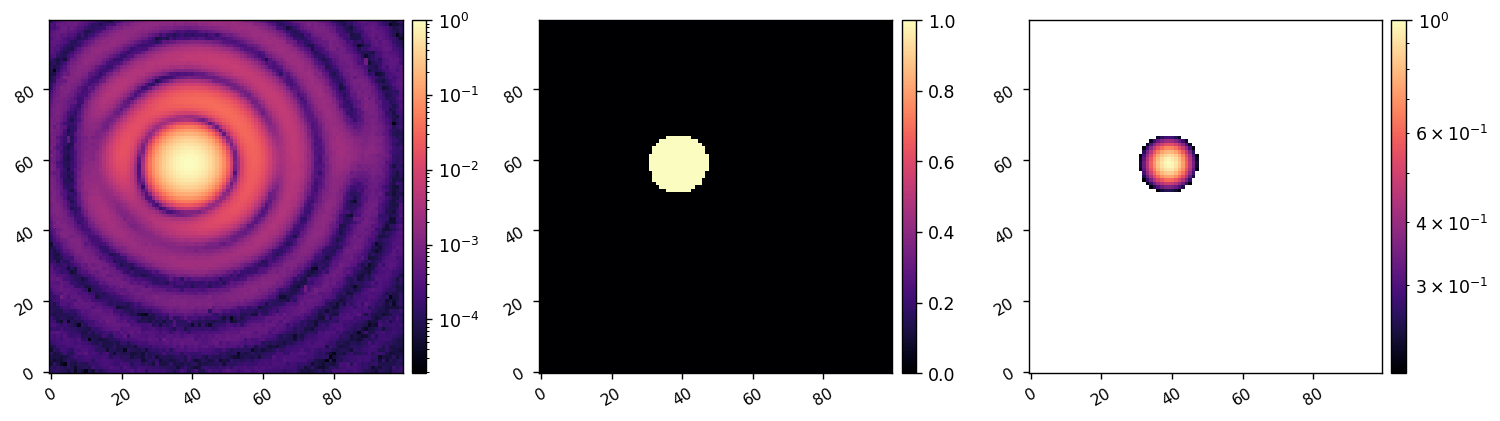

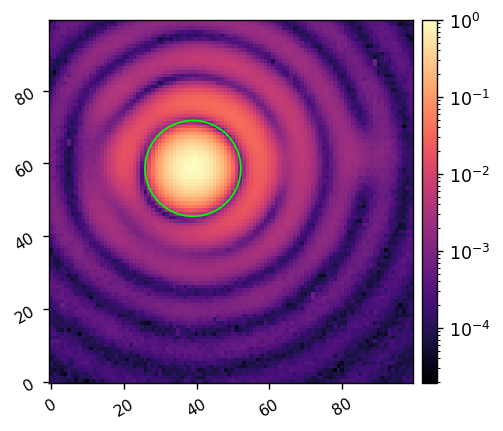

In [47]:

cam.Nframes = 5000
im_2 = cam.snap()

reload(utils)
cen_2 = utils.centroid(im_2, thresh=0.2, plot=True)
imshow1(im_2, lognorm=True, patches=[Circle(cen_2, 1.22/pxscl_lamD, fill=False, color='lime')])


In [42]:
np.sqrt(np.sum(np.square(cen_2))), np.sqrt(np.sum(np.square(cen_1))), np.sqrt(np.sum(np.square(cen_diff)))

(np.float64(70.47654811114353),
 np.float64(71.50072232508595),
 np.float64(22.484554787547438))

In [50]:
cen_diff = cen_2 - cen_1
print(cen_diff)
print('Expected shift [lamda/D]: ', tip)
print('Expected shift [as]: ', tip*as_per_lamD)
shift_pix = np.sqrt(np.sum(np.square(cen_diff)))
shift_lamD = shift_pix * pxscl_lamD
shift_as = shift_lamD * as_per_lamD
print('Expected shift [lamda/D]: ', tip)
print('Expected shift [as]: ', tip*as_per_lamD)

[-2.95598296  1.61369371]
Expected shift [lamda/D]:  0.2
Expected shift [as]:  3.840165363365059 arcsec
0.3120370156970319
5.9913686988377055 arcsec


In [58]:
fsm = ImageStream('fsm')
fsm.write(0*v_bias)

In [66]:
v_tt = fsm_utils.get_fsm_volts(tip=0*as_per_lamD, tilt=2*as_per_lamD)
volts = [v_bias, v_tt]
freq = 2
try:
    print('Modulating FSM ...')
    i = 0
    while True:
        fsm.write(volts[i%2])
        i += 1 
        time.sleep(1/freq)
except KeyboardInterrupt:
    print('FSM modulation stopped!')
    fsm.write(v_bias)


Displacements: A = 5.64e-06 m, 4.68e-06 m, 4.68e-06 m. 
Delta Voltages: A = 56.45, B = 46.78, C = 46.78. 
Modulating FSM ...
FSM modulation stopped!


In [57]:
12*as_per_lamD.to(u.microradian)

<Quantity 1055. urad>

In [9]:
amp = 1*as_per_lamD

freq = 1*u.Hz
t_max = (1/freq).to(u.s)
Nsamps = 73
times = np.linspace(0, t_max, Nsamps)
delt = (times[1]-times[0]).to_value(u.s)

tip_wave = amp*np.sin(2*np.pi*freq.to_value(u.Hz)*times.to_value(u.s))/np.sqrt(2)
tilt_wave = amp*np.cos(2*np.pi*freq.to_value(u.Hz)*times.to_value(u.s))/np.sqrt(2)
volt_commands = np.zeros((Nsamps, 3, 1))
for i in range(Nsamps):
    volt_commands[i] = fsm_utils.get_fsm_volts(tip=tip_wave[i], tilt=tilt_wave[i])

Displacements: A = 5.00e-06 m, 5.37e-06 m, 4.63e-06 m. 
Delta Voltages: A = 50.00, B = 53.73, C = 46.27. 
Displacements: A = 5.04e-06 m, 5.35e-06 m, 4.61e-06 m. 
Delta Voltages: A = 50.38, B = 53.53, C = 46.10. 
Displacements: A = 5.07e-06 m, 5.33e-06 m, 4.60e-06 m. 
Delta Voltages: A = 50.75, B = 53.30, C = 45.95. 
Displacements: A = 5.11e-06 m, 5.30e-06 m, 4.58e-06 m. 
Delta Voltages: A = 51.11, B = 53.05, C = 45.84. 
Displacements: A = 5.15e-06 m, 5.28e-06 m, 4.58e-06 m. 
Delta Voltages: A = 51.47, B = 52.77, C = 45.76. 
Displacements: A = 5.18e-06 m, 5.25e-06 m, 4.57e-06 m. 
Delta Voltages: A = 51.82, B = 52.47, C = 45.71. 
Displacements: A = 5.22e-06 m, 5.22e-06 m, 4.57e-06 m. 
Delta Voltages: A = 52.15, B = 52.15, C = 45.69. 
Displacements: A = 5.25e-06 m, 5.18e-06 m, 4.57e-06 m. 
Delta Voltages: A = 52.47, B = 51.82, C = 45.71. 
Displacements: A = 5.28e-06 m, 5.15e-06 m, 4.58e-06 m. 
Delta Voltages: A = 52.77, B = 51.47, C = 45.76. 
Displacements: A = 5.30e-06 m, 5.11e-06 m, 4.5

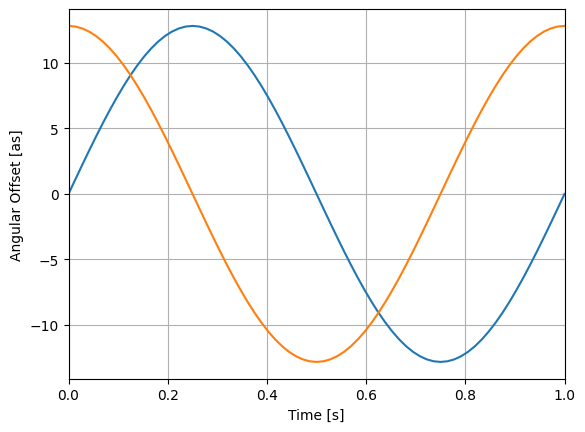

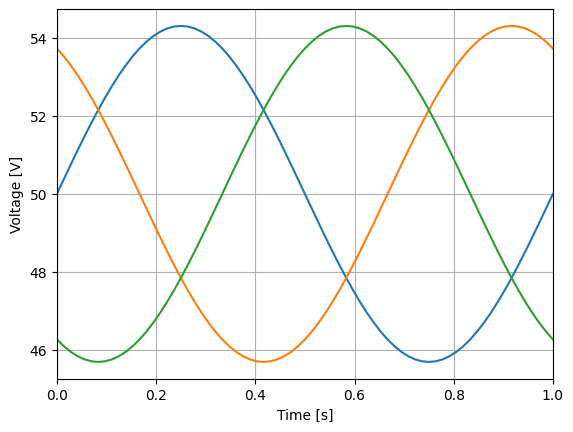

In [10]:
import matplotlib.pyplot as plt
plt.plot(times, tip_wave)
plt.plot(times, tilt_wave)
plt.xlim([0, t_max.to_value(u.s)])
plt.xlabel('Time [s]')
plt.ylabel('Angular Offset [as]')
plt.grid()
plt.show()

plt.plot(times, volt_commands[:,0])
plt.plot(times, volt_commands[:,1])
plt.plot(times, volt_commands[:,2])
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.xlim([0, t_max.to_value(u.s)])
plt.grid()
plt.show()

In [12]:
freq = 1/2 * Nsamps
try:
    print('Modulating FSM ...')
    i = 0
    while i<Nsamps+1:
        if i==Nsamps:
            i = 0
        fsm.write(volt_commands[i])
        time.sleep(1/freq)
        i += 1
        # print(i)
except KeyboardInterrupt:
    print('FSM modulation stopped!')
    fsm.write(v_bias)

Modulating FSM ...
FSM modulation stopped!
